#Running SPUD with Profile and Progressions as Domains

In [1]:
#Import necessary libraries

import sys
import os
import importlib

# Make it so you can get modules from the parent directory
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.insert(0, parent_dir)

import test_manifold_algorithms as tma
from MASH import MASH
import SPUD
importlib.reload(SPUD)
from SPUD import SPUD
import temporal_progression_comparisons
importlib.reload(temporal_progression_comparisons)
from temporal_progression_comparisons import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


This is not running as __main__
This is not running as __main__


In [2]:
LABEL_VARIABLE = "DX_bl"
SAMPLE_SIZE = 300 #set to "all" to get the entire dataset

profile_raw = pd.read_excel(r"..\..\CSV Files\Profile Variables 2024-07-31.xlsx", index_col="RID")
progressions_raw = pd.read_excel(r"..\..\CSV Files\Progression Variables 2024-08-17.xlsx", index_col = [0,1]) #multilevel index

#drop empty rows
profile_raw.dropna(how="all", inplace=True)
progressions_raw.dropna(how="all", inplace=True)

#if all of the data is to be used, simply set the sample size to be all of the available patients
if SAMPLE_SIZE == "all":
    SAMPLE_SIZE = len(profile_raw)

#remap and delete a few variables, might make part of the merge later to be more steamlined on when to map and delete stuff
profile_raw['DX_bl'] = profile_raw['DX_bl'].map({'CN': 0, 'SMC': 1, 'EMCI': 2, 'LMCI': 3, 'AD': 4, 'NaN': -4, -4: -4})
profile_raw['PTMARRY'] = profile_raw['PTMARRY'].map({'Married': 1, 'Widowed': 2, 'Divorced': 3, 'Never married': 4, 'Unknown': -4, 'NaN': -4, -4: -4})

profile = profile_raw.drop(columns = [LABEL_VARIABLE, "PTRACCAT"])
progressions = progressions_raw.drop(columns = [])

label_column = profile_raw[LABEL_VARIABLE].fillna(-4)

In [3]:
#take the first SAMPLE_SIZE of people for domain_a
domain_a = np.array(profile)[:SAMPLE_SIZE].astype(float)

#get the unique rids in the sample and their corresponding visits for domain_b
sample_rids = list(profile.index.values)[:SAMPLE_SIZE]
progressions_sample = progressions.loc[progressions.index.get_level_values(0).isin(sample_rids)] #must be done this way because some of the sample_rids don't have any progressions
domain_b = progressions_sample #our custom comparison function takes a dataframe, so don't transform into array

#build the anchors list from the indecies of the corresponding RID labels
profile_anchors = list(profile.index.values)[:len(domain_a)]
progressions_anchors = list(progressions_sample.index.get_level_values(0).unique())

#make an anchor for every progression with its corresponding profile's position
anchors = []
for index, item in enumerate(progressions_anchors):
    corresponding_profile_position = profile_anchors.index(item)
    new_anchor = [corresponding_profile_position, index]
    anchors.append(new_anchor)

#build the labels list
domain_a_labels = label_column[profile_anchors]
domain_b_labels = label_column[progressions_anchors]
labels = pd.concat([domain_a_labels, domain_b_labels])

In [4]:
#this is the part that's gonna take a while, adjust SAMPLE_SIZE as needed
precomputed_data = wrapped_euclidean_distances(domain_b)

In [5]:
pp_spud = SPUD(n_pca = 10, distance_measure_A = "euclidean", distance_measure_B = "precomputed")
pp_spud.fit(domain_a, precomputed_data, known_anchors = anchors)

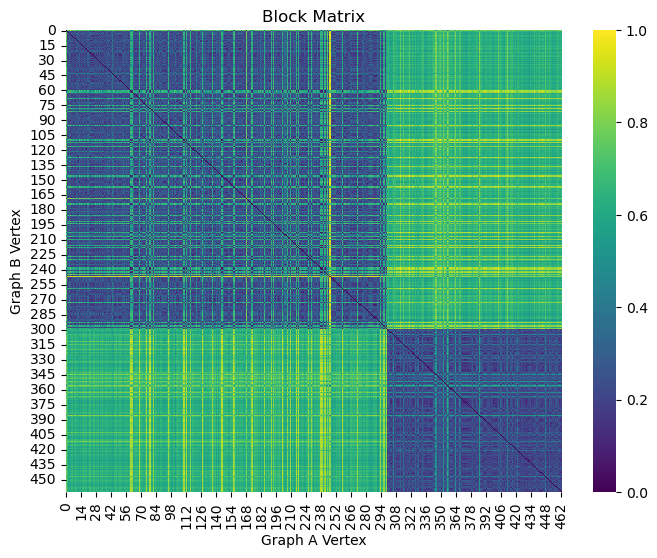

c:\Users\jcory\anaconda3\Lib\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


Cross Embedding: 0.2797034764826176
Can't compute FOSCTTM with different domain shapes.


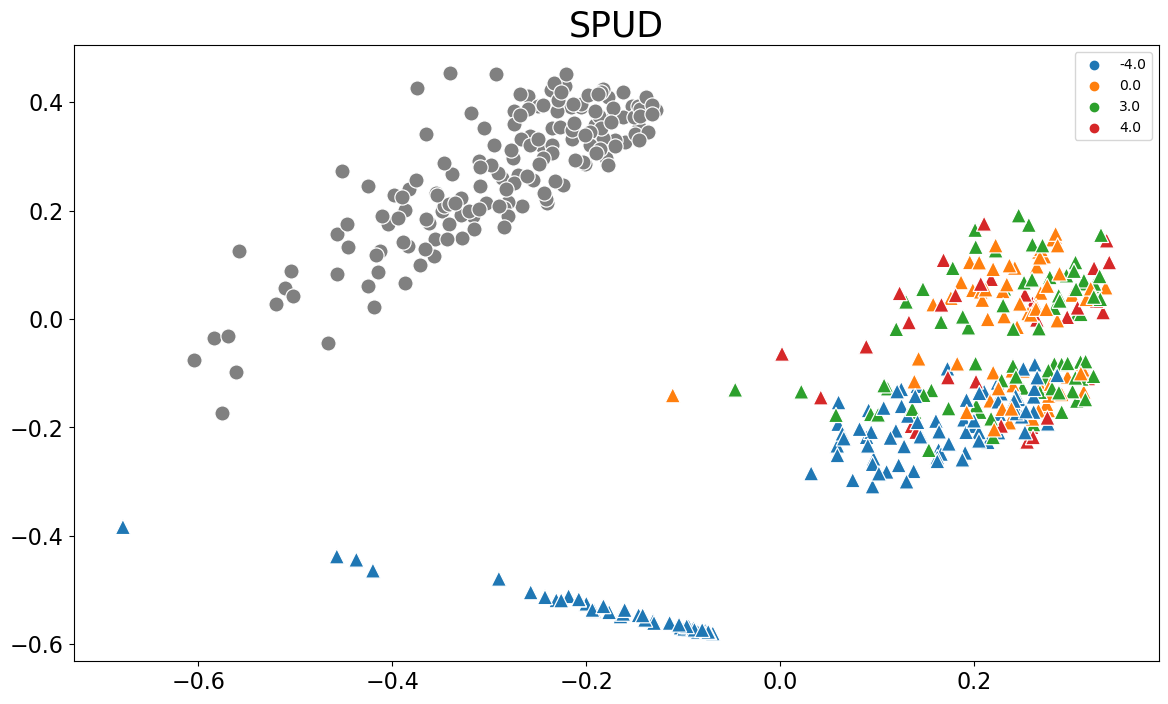

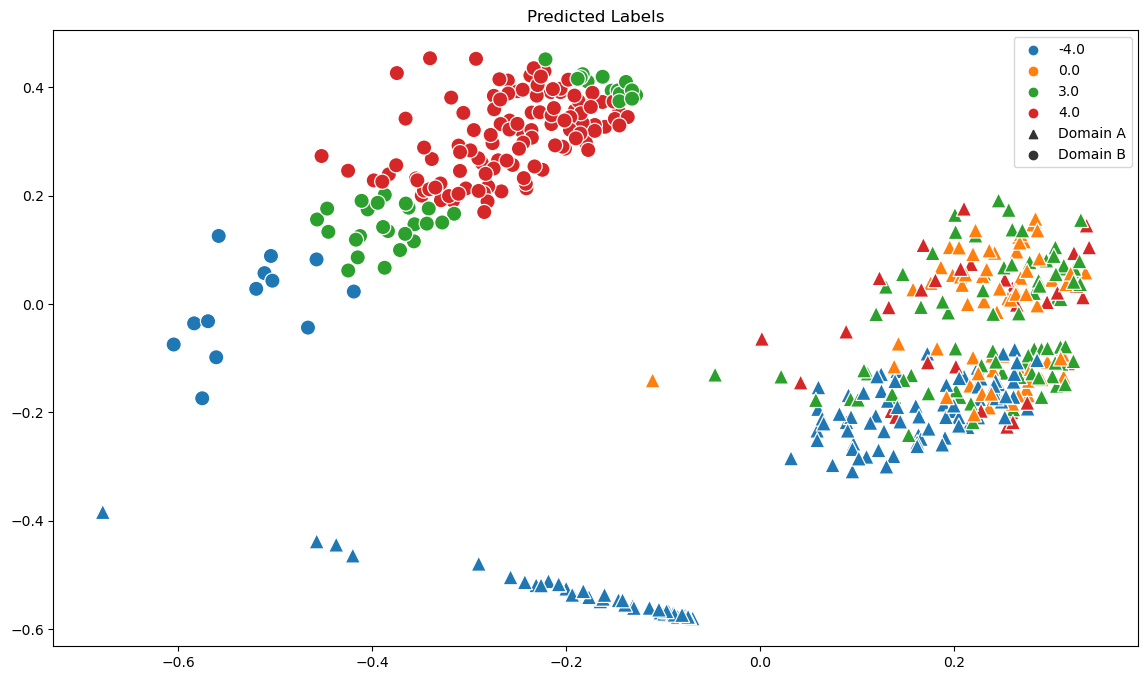

In [6]:
#Create the merged values --> This will take up the rest of your day
#pp_spud = SPUD(n_pca = 10, distance_measure_A = "euclidean", distance_measure_B = wrapped_euclidean_distances)
#pp_spud.fit(domain_a, domain_b, known_anchors = anchors)
pp_spud.plot_heat_map()
#pp_spud.plot_graphs()
pp_spud.plot_emb(labels = labels, show_anchors = False, show_lines = False, n_comp = 2, show_pred = True)